[![Google Colab][colab-badge]][colab-url]

[![Deepnote][deepnote-badge]][deepnote-url]

[colab-badge]: https://colab.research.google.com/assets/colab-badge.svg
[colab-url]: https://colab.research.google.com/github/farhanreynaldo/side-project/blob/master/approximate-bayesian-computation.ipynb
[deepnote-badge]: https://beta.deepnote.com/buttons/launch-in-deepnote.svg
[deepnote-url]: https://beta.deepnote.com/launch?template=data-science&url=https%3A//github.com/farhanreynaldo/side-project/blob/master/approximate-bayesian-computation.ipynb

## Approximate Bayesian Computation

> This notebook based on Rasmus Bååth's post [Tiny Data, Approximate Bayesian Computation and the Socks of Karl Broman](http://www.sumsar.net/blog/2014/10/tiny-data-and-the-socks-of-karl-broman/)

### Import Library

In [2]:
!pip install seaborn==0.11.0

You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.
^C


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Data Generating Process

In [4]:
np.random.seed(12)

n_socks = 18
n_picked = 11

n_pairs = 7
n_odd = 4

socks = np.repeat(range(n_pairs + n_odd), np.repeat([2, 1], [7, 4]))
picked_socks = np.random.choice(socks, size=min(n_picked, n_socks), replace=False)
socks_count = pd.Series(picked_socks).value_counts()

dict(pairs = sum(socks_count == 2), odd = sum(socks_count == 1))

{'pairs': 2, 'odd': 7}

### Prior Setup

In [5]:
data_points = 10000
prior_mu = 30
prior_sd = 15

# https://stackoverflow.com/questions/62454956/parameterization-of-the-negative-binomial-in-scipy-via-mean-and-std
prior_prob = prior_mu / prior_sd**2
prior_size = prior_mu * prior_prob / (1 - prior_prob)

# number of socks model by negative binomial
n_socks = np.random.negative_binomial(n=prior_size, p=prior_prob, size=data_points)

# proportion of pairs model by beta distribution
prop_pairs = np.random.beta(a=15, b=2, size=data_points)
n_pairs = np.round(np.floor(n_socks / 2) * prop_pairs)
n_odd = n_socks - n_pairs * 2

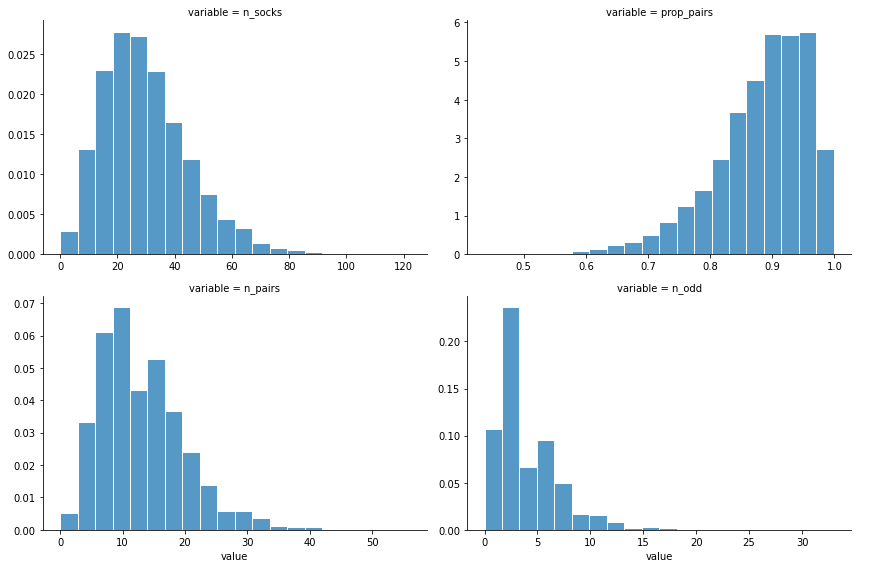

In [6]:
prior_plot = (
    pd.DataFrame(dict(n_socks=n_socks, prop_pairs=prop_pairs, n_pairs=n_pairs, n_odd=n_odd))
    .melt()
    .pipe((sns.FacetGrid, 'data'), col="variable", col_wrap=2, sharex=False,
        sharey=False, height=4, aspect=1.5)
    .map_dataframe(sns.histplot, "value", stat="density", edgecolor='white', bins=20)
    .add_legend()
)
prior_plot

### Socks Simulation

In [ ]:
def simulate_socks(iter=10000):
    data = []

    # parameter for negative binomial prior distribution
    prior_mu, prior_sd = 30, 15
    prior_prob = prior_mu / prior_sd**2
    prior_size = prior_mu * prior_prob / (1 - prior_prob)

    # parameter for beta prior distribution
    a, b = 15, 2

    for _ in range(iter):
        n_socks = np.random.negative_binomial(n=prior_size, p=prior_prob)
        prop_pairs = np.random.beta(a=a, b=b)
        n_pairs = int(np.round(np.floor(n_socks / 2) * prop_pairs))
        n_odd = n_socks - n_pairs * 2

        socks = np.repeat(range(n_pairs + n_odd), np.repeat([2, 1], [n_pairs, n_odd]))
        picked_socks = np.random.choice(socks, size=min(n_picked, n_socks), replace=False)
        socks_count = pd.Series(picked_socks).value_counts()

        sample = (sum(socks_count == 2), sum(socks_count == 1), n_socks, n_pairs, n_odd, prop_pairs)
        data.append(sample)
    return pd.DataFrame(data, columns=['pairs', 'unique', 'n_socks', 'n_pairs', 'n_odd', 'prop_pairs']) 

socks_sim = simulate_socks()
post_samples = socks_sim.query("pairs == 0 & unique == 11")

In [ ]:
def vertical_mean_line(x, **kwargs):
    plt.axvline(x.mean(), linestyle='--', color=kwargs.get("color", "g"))

posterior_plot = (
    # combine prior and posterior
    pd.concat([socks_sim.assign(kind='prior'), post_samples.assign(kind='posterior')])
    .drop(['pairs', 'unique'], axis=1)
    # tidy up
    .melt(id_vars='kind', value_vars=['n_socks', 'n_pairs', 'n_odd', 'prop_pairs'])
    # visualize
    .pipe((sns.FacetGrid, 'data'), col="variable", hue="kind", col_wrap=2,
        sharex=False, sharey=False, height=4, aspect=1.5)
    .map_dataframe(sns.histplot, "value", stat="density", edgecolor='white',
                  common_norm=False, bins=20)
    .add_legend()
    .map(vertical_mean_line, 'value') 
)

In [ ]:
post_samples.median()